In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
from sklearn.decomposition import PCA
from matplotlib.dates import DateFormatter
import os
import pytz
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

/Users/yagmurozdemir/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Notes on my work

The data file I use on this notebook has these pre-processing steps done:
1. the rows where 'suspended' or 'stopped' columns take value 'True' has filtered out from the dataset.
2. For filling of the NA values, firstly the data is grouped into separate dataframes according to the fixture_id. Then, all matches are sorted according to time (based on halftime, minute & second information). Here, any NA values in the first 1 minute of the matches are filled with 0. 
3. Then, for each one of the remaining rows, only  the events that has been occured earlier (only the rows above that instance) are used for calculating the nearest neighbor with k = 1. As the distance measure for the nearest neighbor part, time is used. This way, all of the remaining NA values are filled. 

On this notebook, I will use the data where I have already applied this preprocessing steps (as the other file size became too large). The work done on the pre-processing steps are also added to the repository in both html and ipynb formats.



In [2]:
data_path = '/Users/yagmurozdemir/Desktop'


## task 1 

The aim of this task is to understand if bookmakers are good enough in setting their odds for “draw”
bets. An empirical evidence for the probability of “draw” can be calculated by determining the
certain probability intervals on the implied probabilities by the bookmakers for the specific result.

Once you determine a probability range (i.e. a bookmaker’s implied draw probability is 0.4 for a
specific game and your probability range is 0.38 and 0.42), you can count the games that finished as
draw within this range. In other words, we can discretize probability of draw values into bins (i.e.
(0.00,0.05], (0.05, 0.10], …, (0.95,1.00]) and calculate the number of games ended as “draw” in the
corresponding bin. Dividing this value by the total number of games in the corresponding bin will
provide the estimated probability of “draws”. Please note that implied probabilities may not be larger
than a certain value (since it is not reasonable), modify your bins accordingly if this is the case.

Aforementioned bins are provided for illustration purposes. If people are good enough in in their
beliefs, what you expect to see is that fraction of games finished as “draw" is between this implied
probability range. You will perform the following tasks for each half of the game.

1. Calculate the P(home win), P(tie) and P(away win) by P(x) = 1/odd.
2. Then calculate these probabilities again using normalization formula at “Odds andProbabilities” part.
3. First construct a plot of P(home win) – P(away win) on x-axis and P (tie) on y-axis with first probability calculation; then plot the actual probabilities calculated using the results. In other words, we can discretize P(home win) – P(away win) values into bins (i.e. (-1,-0.8], (- 0.8, -0.6], …, (0.8,1]) and calculate the number of games ended as “Draw” in the corresponding bin. Dividing this value by the total number of games in the corresponding bin will provide the estimated probability of draws. If this probability (calculated from the sample) is larger than the probability proposed by the bookmaker, one can potentially make money in the long run by betting on “Draw” for the games whose odds reside in the corresponding bin.
4. Comment on if there is a bias in odds representing the probabilities? Name the x and y axes accordingly. Write the half at the top of each plot.


In [3]:
data = pd.read_csv(os.path.join(data_path, 'filled_match_groups.csv'))

df = data.copy()
#calculating the implied probabilities
df['P_home'] = 1 / df['1']
df['P_draw'] = 1 / df['X']
df['P_away'] = 1 / df['2']
df


,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,suspended,stopped,...,Yellowcards - away,Yellowcards - home,Yellowred Cards - away,Yellowred Cards - home,current_state,final_score,result,P_home,P_draw,P_away
0,19134453.0,1st-half,2024-08-16 19:01:19,2024-08-16 19:00:31,2024-08-16 19:00:31,0,48,2024-08-16 19:01:17,False,False,...,0.0,0.0,0.0,0.0,X,1-0,1,0.602410,0.250000,0.200000
1,19134453.0,1st-half,2024-08-16 19:02:18,2024-08-16 19:00:31,2024-08-16 19:00:31,1,47,2024-08-16 19:02:16,False,False,...,0.0,0.0,0.0,0.0,X,1-0,1,0.602410,0.250000,0.200000
2,19134453.0,1st-half,2024-08-16 19:03:19,2024-08-16 19:00:31,2024-08-16 19:00:31,2,48,2024-08-16 19:03:15,False,False,...,0.0,0.0,0.0,0.0,X,1-0,1,0.621118,0.250000,0.181818
3,19134453.0,1st-half,2024-08-16 19:04:18,2024-08-16 19:00:31,2024-08-16 19:00:31,3,47,2024-08-16 19:04:08,False,False,...,0.0,0.0,0.0,0.0,X,1-0,1,0.621118,0.250000,0.200000
4,19134453.0,1st-half,2024-08-16 19:05:19,2024-08-16 19:00:31,2024-08-16 19:00:31,4,48,2024-08-16 19:05:15,False,False,...,0.0,0.0,0.0,0.0,X,1-0,1,0.621118,0.250000,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56122,19172117.0,2nd-half,2024-11-10 17:48:41,2024-11-10 17:15:56,2024-11-10 16:03:27,32,45,2024-11-10 17:48:37,False,False,...,5.0,0.0,0.0,0.0,1,4-0,1,1.000000,0.019608,0.002494
56123,19172117.0,2nd-half,2024-11-10 17:49:41,2024-11-10 17:15:56,2024-11-10 16:03:27,33,45,2024-11-10 17:49:39,False,False,...,5.0,0.0,0.0,0.0,1,4-0,1,1.000000,0.019608,0.002494
56124,19172117.0,2nd-half,2024-11-10 17:50:42,2024-11-10 17:15:56,2024-11-10 16:03:27,34,46,2024-11-10 17:50:39,False,False,...,5.0,0.0,0.0,0.0,1,4-0,1,1.000000,0.019608,0.002849
56125,19172117.0,2nd-half,2024-11-10 17:51:41,2024-11-10 17:15:56,2024-11-10 16:03:27,35,45,2024-11-10 17:51:40,False,False,...,5.0,0.0,0.0,0.0,1,4-0,1,1.000000,0.019608,0.002494


In [4]:
#normalizing the probabilities
df['P_sum'] = df['P_home'] + df['P_draw'] + df['P_away']
df['P_home_normalized'] = df['P_home'] / df['P_sum']
df['P_draw_normalized'] = df['P_draw'] / df['P_sum']
df['P_away_normalized'] = df['P_away'] / df['P_sum']
df

,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,suspended,stopped,...,current_state,final_score,result,P_home,P_draw,P_away,P_sum,P_home_normalized,P_draw_normalized,P_away_normalized
0,19134453.0,1st-half,2024-08-16 19:01:19,2024-08-16 19:00:31,2024-08-16 19:00:31,0,48,2024-08-16 19:01:17,False,False,...,X,1-0,1,0.602410,0.250000,0.200000,1.052410,0.572410,0.237550,0.190040
1,19134453.0,1st-half,2024-08-16 19:02:18,2024-08-16 19:00:31,2024-08-16 19:00:31,1,47,2024-08-16 19:02:16,False,False,...,X,1-0,1,0.602410,0.250000,0.200000,1.052410,0.572410,0.237550,0.190040
2,19134453.0,1st-half,2024-08-16 19:03:19,2024-08-16 19:00:31,2024-08-16 19:00:31,2,48,2024-08-16 19:03:15,False,False,...,X,1-0,1,0.621118,0.250000,0.181818,1.052936,0.589891,0.237431,0.172677
3,19134453.0,1st-half,2024-08-16 19:04:18,2024-08-16 19:00:31,2024-08-16 19:00:31,3,47,2024-08-16 19:04:08,False,False,...,X,1-0,1,0.621118,0.250000,0.200000,1.071118,0.579878,0.233401,0.186721
4,19134453.0,1st-half,2024-08-16 19:05:19,2024-08-16 19:00:31,2024-08-16 19:00:31,4,48,2024-08-16 19:05:15,False,False,...,X,1-0,1,0.621118,0.250000,0.200000,1.071118,0.579878,0.233401,0.186721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56122,19172117.0,2nd-half,2024-11-10 17:48:41,2024-11-10 17:15:56,2024-11-10 16:03:27,32,45,2024-11-10 17:48:37,False,False,...,1,4-0,1,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440
56123,19172117.0,2nd-half,2024-11-10 17:49:41,2024-11-10 17:15:56,2024-11-10 16:03:27,33,45,2024-11-10 17:49:39,False,False,...,1,4-0,1,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440
56124,19172117.0,2nd-half,2024-11-10 17:50:42,2024-11-10 17:15:56,2024-11-10 16:03:27,34,46,2024-11-10 17:50:39,False,False,...,1,4-0,1,1.000000,0.019608,0.002849,1.022457,0.978036,0.019177,0.002786
56125,19172117.0,2nd-half,2024-11-10 17:51:41,2024-11-10 17:15:56,2024-11-10 16:03:27,35,45,2024-11-10 17:51:40,False,False,...,1,4-0,1,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440


In [5]:
# differences between P(home win) and P(away win)
df['delta_P'] = df['P_home'] - df['P_away']
df['delta_P_normalized'] = df['P_home_normalized'] - df['P_away_normalized']

/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6703/2135152789.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  draw_prob_by_bin = df.groupby('delta_P_bin')['P_draw_normalized'].mean()
/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6703/2135152789.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  draw_count_by_bin = df.groupby('delta_P_bin')['result'].apply(lambda x: (x == 'X').sum())
/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6703/2135152789.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas

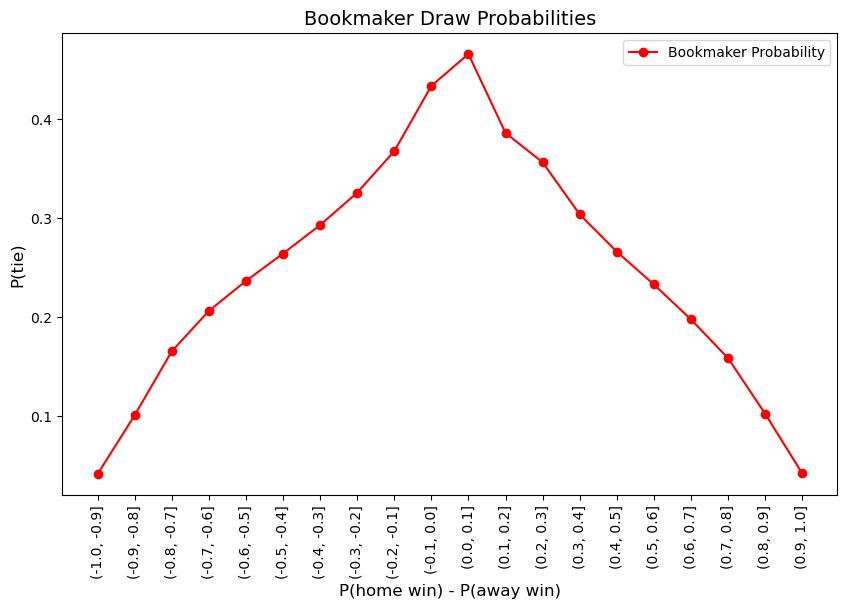

In [6]:


# discretize delta_P into bins
bins = np.linspace(-1, 1, 21)  # 20 bins from -1 to 1


df['delta_P_bin'] = pd.cut(df['delta_P_normalized'], bins=bins)

# calculating the estimated probability of draw for each bin by taking the mean 
draw_prob_by_bin = df.groupby('delta_P_bin')['P_draw_normalized'].mean()

# counting the number of games that ended in a draw for each bin
draw_count_by_bin = df.groupby('delta_P_bin')['result'].apply(lambda x: (x == 'X').sum())

# the total number of games in each bin
total_count_by_bin = df.groupby('delta_P_bin').size()

# the estimated probability of draws in each bin
estimated_prob_draw = draw_count_by_bin / total_count_by_bin

# calculating the difference between the estimated probability of draws and the bookmaker's P_draw
df['draw_diff'] = estimated_prob_draw[df['delta_P_bin']].values -  df['P_draw_normalized']

# Plotting the bookmaker probabilities using lines
plt.figure(figsize=(10, 6))

plt.plot(draw_prob_by_bin.index.astype(str), draw_prob_by_bin.values, label='Bookmaker Probability', color='red', marker='o')

plt.xlabel('P(home win) - P(away win)', fontsize=12)
plt.ylabel('P(tie)', fontsize=12)
plt.title('Bookmaker Draw Probabilities', fontsize=14)
plt.xticks(rotation=90)  
plt.legend()

plt.show()

In [7]:
df['draw_diff'].mean()

0.009338537240424301

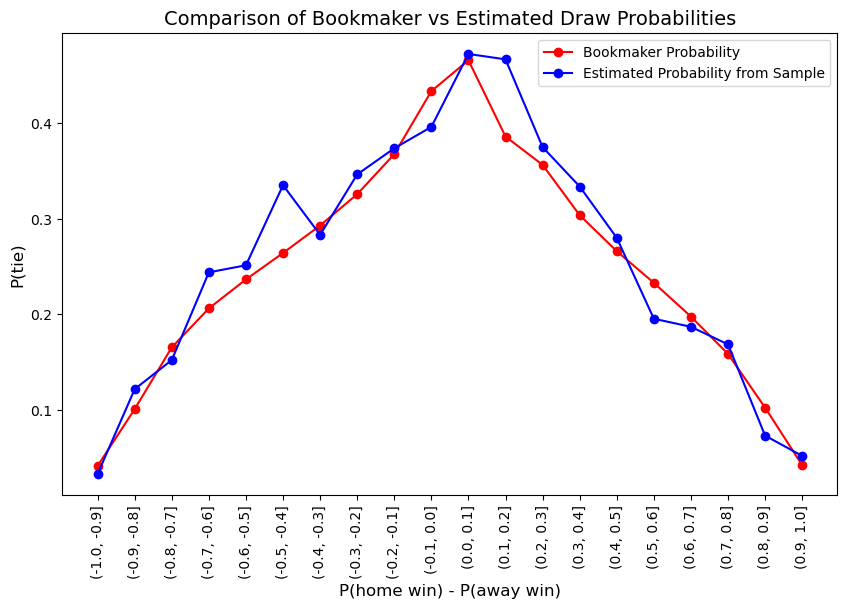

In [8]:
# Plotting the comparison using lines
plt.figure(figsize=(10, 6))

# Plotting the bookmaker probabilities as a line
plt.plot(draw_prob_by_bin.index.astype(str), draw_prob_by_bin.values, label='Bookmaker Probability', color='red', marker='o')

# Plotting the estimated probabilities as a line
plt.plot(estimated_prob_draw.index.astype(str), estimated_prob_draw.values, label='Estimated Probability from Sample', color='blue', marker='o')

# Adding labels and title
plt.xlabel('P(home win) - P(away win)', fontsize=12)
plt.ylabel('P(tie)', fontsize=12)
plt.title('Comparison of Bookmaker vs Estimated Draw Probabilities', fontsize=14)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.legend()

# Show the plot
plt.show()


In [9]:
min_prob_draw = df.groupby('delta_P_bin')['P_draw_normalized'].min()
max_prob_draw = df.groupby('delta_P_bin')['P_draw_normalized'].max()

bin_results_df = pd.DataFrame({
    'Min_P_draw_estimated': min_prob_draw,
    'Max_P_draw_estimated': max_prob_draw,
    'Estimated_P_draw': estimated_prob_draw
}).reset_index()
bin_results_df

/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6703/561186629.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  min_prob_draw = df.groupby('delta_P_bin')['P_draw_normalized'].min()
/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6703/561186629.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_prob_draw = df.groupby('delta_P_bin')['P_draw_normalized'].max()


,delta_P_bin,Min_P_draw_estimated,Max_P_draw_estimated,Estimated_P_draw
0,"(-1.0, -0.9]",0.019082,0.086860,0.032928
1,"(-0.9, -0.8]",0.049986,0.171719,0.121766
2,"(-0.8, -0.7]",0.098840,0.251504,0.152206
3,"(-0.7, -0.6]",0.116555,0.309963,0.244040
4,"(-0.6, -0.5]",0.165507,0.374155,0.251451
5,"(-0.5, -0.4]",0.171838,0.484045,0.335306
6,"(-0.4, -0.3]",0.207744,0.563486,0.283305
7,"(-0.3, -0.2]",0.217237,0.688559,0.346589
8,"(-0.2, -0.1]",0.233397,0.857114,0.373924
9,"(-0.1, 0.0]",0.233776,0.944444,0.396302


- The first plot shows bookmaker-provided probabilities for ties as a function of  P(\text{home win}) - P(\text{away win}) .
- The second plot overlays the estimated draw probabilities calculated from sample data onto the bookmaker probabilities.
- The discrepancies between the two highlight potential biases or misestimations in bookmaker odds.

My observations:

1. Mid-range  P(\text{home win}) - P(\text{away win}) : Bookmaker probabilities and sample-estimated probabilities align closely in the mid-range (e.g., near  P(\text{home win}) - P(\text{away win}) \approx 0 ). This suggests bookmakers are relatively accurate in predicting draw probabilities when the game is evenly matched.

2. Extreme  P(\text{home win}) - P(\text{away win}) : For bins closer to -1 (strong away team dominance), bookmaker probabilities for ties tend to deviate from estimated probabilities.Bookmakers appear to underrepresent tie probabilities at these extremes, potentially indicating a systematic bias.

According to the observation 2, we can say that, betting on draws may be profitable in bins where the sample-estimated probabilities of a draw are significantly higher than bookmaker odds. (for bins closer to -1, more specifically the bin where we see the largest difference between estimated and bookmaker probabilities like the bin from -0.4 to -0.5). This strategy, betting for draw on these bins, can lead to profits according to our observations here.


Bias discussions:

The discrepancy between bookmaker odds and empirical probabilities indicates a potential bias in how odds are set, especially for draws.This indicates that bookmakers might deliberately underestimate draw probabilities to hedge against risk or exploit psychological betting tendencies, as bettors often avoid betting on draws. Hence, creating  some bias in these probabilities.

## task 2

Task 2
There can be some events during the matches that create noise in the outcomes. To be more specific,
let’s consider two specific cases:
- Think of a match in which a team wins with a goal towards the end of the game (i.e. the team
scores the winning goal after 90th minute) or similarly match ends draw (tie) or away because
of the same reason.
- Bookings can affect the game result. A red card in the first few minutes of a game can change
the outcome of the match drastically. Playing with few players is always a disadvantage for
the teams.

Perform third and fourth subtask of Task 1 again after removing the matches fitting well to the cases
above. Please clearly mention about your decisions in removing the games (i.e. match is removed if
there is a red card in the first 15 minutes) and provide removed match counts for each cases. Is there
any significant change in the observations you have for Task 1? Comment on the results.

In [10]:
data

,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,suspended,stopped,...,Throwins - home,Total Crosses - away,Total Crosses - home,Yellowcards - away,Yellowcards - home,Yellowred Cards - away,Yellowred Cards - home,current_state,final_score,result
0,19134453.0,1st-half,2024-08-16 19:01:19,2024-08-16 19:00:31,2024-08-16 19:00:31,0,48,2024-08-16 19:01:17,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X,1-0,1
1,19134453.0,1st-half,2024-08-16 19:02:18,2024-08-16 19:00:31,2024-08-16 19:00:31,1,47,2024-08-16 19:02:16,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X,1-0,1
2,19134453.0,1st-half,2024-08-16 19:03:19,2024-08-16 19:00:31,2024-08-16 19:00:31,2,48,2024-08-16 19:03:15,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X,1-0,1
3,19134453.0,1st-half,2024-08-16 19:04:18,2024-08-16 19:00:31,2024-08-16 19:00:31,3,47,2024-08-16 19:04:08,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X,1-0,1
4,19134453.0,1st-half,2024-08-16 19:05:19,2024-08-16 19:00:31,2024-08-16 19:00:31,4,48,2024-08-16 19:05:15,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X,1-0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56122,19172117.0,2nd-half,2024-11-10 17:48:41,2024-11-10 17:15:56,2024-11-10 16:03:27,32,45,2024-11-10 17:48:37,False,False,...,12.0,15.0,20.0,5.0,0.0,0.0,0.0,1,4-0,1
56123,19172117.0,2nd-half,2024-11-10 17:49:41,2024-11-10 17:15:56,2024-11-10 16:03:27,33,45,2024-11-10 17:49:39,False,False,...,12.0,15.0,20.0,5.0,0.0,0.0,0.0,1,4-0,1
56124,19172117.0,2nd-half,2024-11-10 17:50:42,2024-11-10 17:15:56,2024-11-10 16:03:27,34,46,2024-11-10 17:50:39,False,False,...,12.0,15.0,20.0,5.0,0.0,0.0,0.0,1,4-0,1
56125,19172117.0,2nd-half,2024-11-10 17:51:41,2024-11-10 17:15:56,2024-11-10 16:03:27,35,45,2024-11-10 17:51:40,False,False,...,12.0,15.0,21.0,5.0,0.0,0.0,0.0,1,4-0,1


In [11]:
df2 = data.copy()

In [12]:
column_names = df2.columns
for i in column_names:
    print(i)


fixture_id
halftime
current_time
half_start_datetime
match_start_datetime
minute
second
latest_bookmaker_update
suspended
stopped
1
2
X
name
ticking
Accurate Crosses - away
Accurate Crosses - home
Assists - away
Assists - home
Attacks - away
Attacks - home
Ball Possession % - away
Ball Possession % - home
Ball Safe - away
Ball Safe - home
Challenges - away
Challenges - home
Corners - away
Corners - home
Counter Attacks - away
Counter Attacks - home
Dangerous Attacks - away
Dangerous Attacks - home
Dribble Attempts - away
Dribble Attempts - home
Fouls - away
Fouls - home
Free Kicks - away
Free Kicks - home
Goal Attempts - away
Goal Attempts - home
Goal Kicks - away
Goal Kicks - home
Goals - away
Goals - home
Headers - away
Headers - home
Hit Woodwork - away
Hit Woodwork - home
Injuries - away
Injuries - home
Interceptions - away
Interceptions - home
Key Passes - away
Key Passes - home
Long Passes - away
Long Passes - home
Offsides - away
Offsides - home
Passes - away
Passes - home
Penal

In [13]:
late_goal_matches = []

#iterating through each match
for fixture_id, match_data in df2.groupby('fixture_id'):
    #sort the match data by time (minute)
    match_data = match_data.sort_values(by='minute')
    
    # keeping the score at the 89th minute
    score_at_89 = match_data[match_data['minute'] <= 89][['Goals - home', 'Goals - away']].iloc[-1]
    home_goals_89, away_goals_89 = score_at_89['Goals - home'], score_at_89['Goals - away']
    
    # checking for score changes after the 90th minute
    after_90 = match_data[match_data['minute'] > 90]
    for _, row in after_90.iterrows():
        home_goals_after = row['Goals - home']
        away_goals_after = row['Goals - away']
        
        # Conditions:
        # 1. score changed after the 90th minute
        if (home_goals_after != home_goals_89) or (away_goals_after != away_goals_89):
            # 2. difference in scores must be at most 1
            goal_diff_after = abs(home_goals_after - away_goals_after)
            if goal_diff_after <= 1:
                late_goal_matches.append(row)
                break  # stop checking further for same match if already found late goal

late_goal_matches_df = pd.DataFrame(late_goal_matches)

print(f"Total Matches with Significant Late Goals: {len(late_goal_matches_df)}")
print(late_goal_matches_df)

Total Matches with Significant Late Goals: 0
Empty DataFrame
Columns: []
Index: []


Note: 

The filtering approach is for the matches removal due to late goal cases. Firstly, the matches where a goal happens after the 90th minute needs to be taken into consideration. However, we also need to check if the goal changed the course of events in that specific match. 
For example, if the home team is winnig with 2-0 scores, and there is one more goal after the 90th minute and match ends with 3-0 we cannot say that last goal chenged the course of events, hence, we do not need to filter out those cases. 

As a result, I  added the condition of this new goal (after the 90th minute) results in at most 1 difference between the number of goals of the both teams. (hence it filter outs the cases where the goal has changed the result of the match drastically).

However, for the second case (matches where an early red card occurs), we can directly filter the first 15 minutes of the matches and check whether if the number of redcards is different than 0 for either of the teams. 

In [14]:


#matches with early red card (in first 15 minutes)
early_red_card_matches = df2[
    (df2['minute'] <= 15) & 
    ((df2['Redcards - home'] > 0) | (df2['Redcards - away'] > 0))
]

noisy_matches = early_red_card_matches.copy() ## as the Total Matches with Significant Late Goals == 0


#filtering out the matches that has been found as noise
cleaned_df = df2[~df2['fixture_id'].isin(noisy_matches['fixture_id'])]

print(f"Number of matches removed due to early red cards: {len(early_red_card_matches['fixture_id'].unique())}")
print(f"Total matches removed: {len(noisy_matches['fixture_id'].unique())}")
print(f"Remaining matches: {cleaned_df['fixture_id'].nunique()}")



Number of matches removed due to early red cards: 42
Total matches removed: 42
Remaining matches: 606


In [15]:
cleaned_df

,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,suspended,stopped,...,Throwins - home,Total Crosses - away,Total Crosses - home,Yellowcards - away,Yellowcards - home,Yellowred Cards - away,Yellowred Cards - home,current_state,final_score,result
0,19134453.0,1st-half,2024-08-16 19:01:19,2024-08-16 19:00:31,2024-08-16 19:00:31,0,48,2024-08-16 19:01:17,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X,1-0,1
1,19134453.0,1st-half,2024-08-16 19:02:18,2024-08-16 19:00:31,2024-08-16 19:00:31,1,47,2024-08-16 19:02:16,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X,1-0,1
2,19134453.0,1st-half,2024-08-16 19:03:19,2024-08-16 19:00:31,2024-08-16 19:00:31,2,48,2024-08-16 19:03:15,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X,1-0,1
3,19134453.0,1st-half,2024-08-16 19:04:18,2024-08-16 19:00:31,2024-08-16 19:00:31,3,47,2024-08-16 19:04:08,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X,1-0,1
4,19134453.0,1st-half,2024-08-16 19:05:19,2024-08-16 19:00:31,2024-08-16 19:00:31,4,48,2024-08-16 19:05:15,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X,1-0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56122,19172117.0,2nd-half,2024-11-10 17:48:41,2024-11-10 17:15:56,2024-11-10 16:03:27,32,45,2024-11-10 17:48:37,False,False,...,12.0,15.0,20.0,5.0,0.0,0.0,0.0,1,4-0,1
56123,19172117.0,2nd-half,2024-11-10 17:49:41,2024-11-10 17:15:56,2024-11-10 16:03:27,33,45,2024-11-10 17:49:39,False,False,...,12.0,15.0,20.0,5.0,0.0,0.0,0.0,1,4-0,1
56124,19172117.0,2nd-half,2024-11-10 17:50:42,2024-11-10 17:15:56,2024-11-10 16:03:27,34,46,2024-11-10 17:50:39,False,False,...,12.0,15.0,20.0,5.0,0.0,0.0,0.0,1,4-0,1
56125,19172117.0,2nd-half,2024-11-10 17:51:41,2024-11-10 17:15:56,2024-11-10 16:03:27,35,45,2024-11-10 17:51:40,False,False,...,12.0,15.0,21.0,5.0,0.0,0.0,0.0,1,4-0,1


In [16]:
#again calculating the implied probabilities
cleaned_df['P_home'] = 1 / cleaned_df['1']
cleaned_df['P_tie'] = 1 / cleaned_df['X']
cleaned_df['P_away'] = 1 / cleaned_df['2']

/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6703/1593202983.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['P_home'] = 1 / cleaned_df['1']
/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6703/1593202983.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['P_tie'] = 1 / cleaned_df['X']
/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6703/1593202983.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [17]:
cleaned_df

,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,suspended,stopped,...,Yellowcards - away,Yellowcards - home,Yellowred Cards - away,Yellowred Cards - home,current_state,final_score,result,P_home,P_tie,P_away
0,19134453.0,1st-half,2024-08-16 19:01:19,2024-08-16 19:00:31,2024-08-16 19:00:31,0,48,2024-08-16 19:01:17,False,False,...,0.0,0.0,0.0,0.0,X,1-0,1,0.602410,0.250000,0.200000
1,19134453.0,1st-half,2024-08-16 19:02:18,2024-08-16 19:00:31,2024-08-16 19:00:31,1,47,2024-08-16 19:02:16,False,False,...,0.0,0.0,0.0,0.0,X,1-0,1,0.602410,0.250000,0.200000
2,19134453.0,1st-half,2024-08-16 19:03:19,2024-08-16 19:00:31,2024-08-16 19:00:31,2,48,2024-08-16 19:03:15,False,False,...,0.0,0.0,0.0,0.0,X,1-0,1,0.621118,0.250000,0.181818
3,19134453.0,1st-half,2024-08-16 19:04:18,2024-08-16 19:00:31,2024-08-16 19:00:31,3,47,2024-08-16 19:04:08,False,False,...,0.0,0.0,0.0,0.0,X,1-0,1,0.621118,0.250000,0.200000
4,19134453.0,1st-half,2024-08-16 19:05:19,2024-08-16 19:00:31,2024-08-16 19:00:31,4,48,2024-08-16 19:05:15,False,False,...,0.0,0.0,0.0,0.0,X,1-0,1,0.621118,0.250000,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56122,19172117.0,2nd-half,2024-11-10 17:48:41,2024-11-10 17:15:56,2024-11-10 16:03:27,32,45,2024-11-10 17:48:37,False,False,...,5.0,0.0,0.0,0.0,1,4-0,1,1.000000,0.019608,0.002494
56123,19172117.0,2nd-half,2024-11-10 17:49:41,2024-11-10 17:15:56,2024-11-10 16:03:27,33,45,2024-11-10 17:49:39,False,False,...,5.0,0.0,0.0,0.0,1,4-0,1,1.000000,0.019608,0.002494
56124,19172117.0,2nd-half,2024-11-10 17:50:42,2024-11-10 17:15:56,2024-11-10 16:03:27,34,46,2024-11-10 17:50:39,False,False,...,5.0,0.0,0.0,0.0,1,4-0,1,1.000000,0.019608,0.002849
56125,19172117.0,2nd-half,2024-11-10 17:51:41,2024-11-10 17:15:56,2024-11-10 16:03:27,35,45,2024-11-10 17:51:40,False,False,...,5.0,0.0,0.0,0.0,1,4-0,1,1.000000,0.019608,0.002494


/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6703/904389245.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['P_sum'] = cleaned_df['P_home'] + cleaned_df['P_tie'] + cleaned_df['P_away']
/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6703/904389245.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['P_home_normalized'] = cleaned_df['P_home'] / cleaned_df['P_sum']
/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6703/904389245.py:4: SettingWithCopy

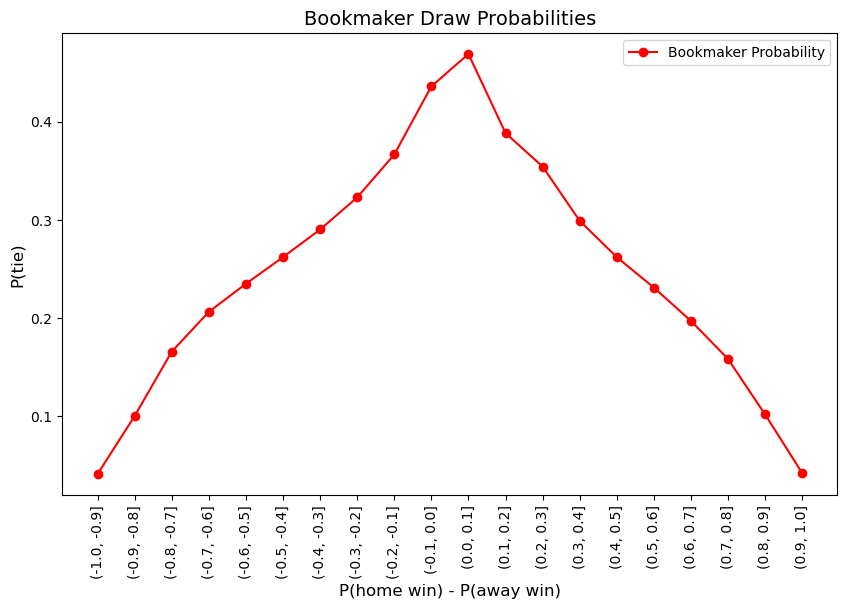

In [18]:
#normalizing the probabilities
cleaned_df['P_sum'] = cleaned_df['P_home'] + cleaned_df['P_tie'] + cleaned_df['P_away']
cleaned_df['P_home_normalized'] = cleaned_df['P_home'] / cleaned_df['P_sum']
cleaned_df['P_draw_normalized'] = cleaned_df['P_tie'] / cleaned_df['P_sum']
cleaned_df['P_away_normalized'] = cleaned_df['P_away'] / cleaned_df['P_sum']


# differences between P(home win) and P(away win)
cleaned_df['delta_P'] = cleaned_df['P_home'] - cleaned_df['P_away']
cleaned_df['delta_P_normalized'] = cleaned_df['P_home_normalized'] - cleaned_df['P_away_normalized']




bins = np.linspace(-1, 1, 21)  # 20 bins from -1 to 1


cleaned_df['delta_P_bin'] = pd.cut(cleaned_df['delta_P_normalized'], bins=bins)

# calculating the estimated probability of draw for each bin by taking the mean 
draw_prob_by_bin2 = cleaned_df.groupby('delta_P_bin')['P_draw_normalized'].mean()

# counting the number of games that ended in a draw for each bin
draw_count_by_bin2 = cleaned_df.groupby('delta_P_bin')['result'].apply(lambda x: (x == 'X').sum())

# the total number of games in each bin
total_count_by_bin2 = cleaned_df.groupby('delta_P_bin').size()

# the estimated probability of draws in each bin
estimated_prob_draw2 = draw_count_by_bin2 / total_count_by_bin2

# calculating the difference between the estimated probability of draws and the bookmaker's P_draw
cleaned_df['draw_diff'] = estimated_prob_draw2[cleaned_df['delta_P_bin']].values -  cleaned_df['P_draw_normalized']




# Plotting the bookmaker probabilities using lines
plt.figure(figsize=(10, 6))

plt.plot(draw_prob_by_bin2.index.astype(str), draw_prob_by_bin2.values, label='Bookmaker Probability', color='red', marker='o')

plt.xlabel('P(home win) - P(away win)', fontsize=12)
plt.ylabel('P(tie)', fontsize=12)
plt.title('Bookmaker Draw Probabilities', fontsize=14)
plt.xticks(rotation=90)  
plt.legend()

plt.show()

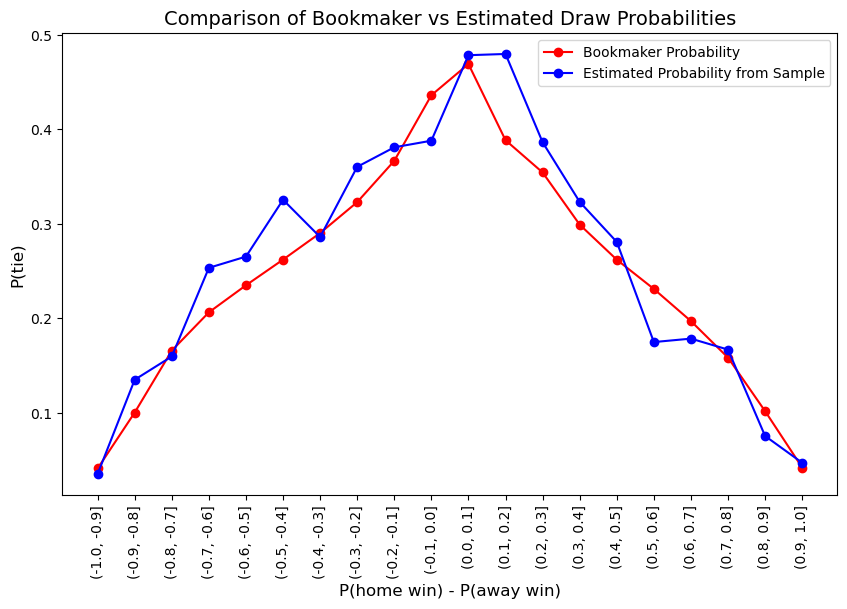

In [19]:
# Plotting the comparison using lines
plt.figure(figsize=(10, 6))

# Plotting the bookmaker probabilities as a line
plt.plot(draw_prob_by_bin2.index.astype(str), draw_prob_by_bin2.values, label='Bookmaker Probability', color='red', marker='o')

# Plotting the estimated probabilities as a line
plt.plot(estimated_prob_draw2.index.astype(str), estimated_prob_draw2.values, label='Estimated Probability from Sample', color='blue', marker='o')

# Adding labels and title
plt.xlabel('P(home win) - P(away win)', fontsize=12)
plt.ylabel('P(tie)', fontsize=12)
plt.title('Comparison of Bookmaker vs Estimated Draw Probabilities', fontsize=14)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.legend()

# Show the plot
plt.show()


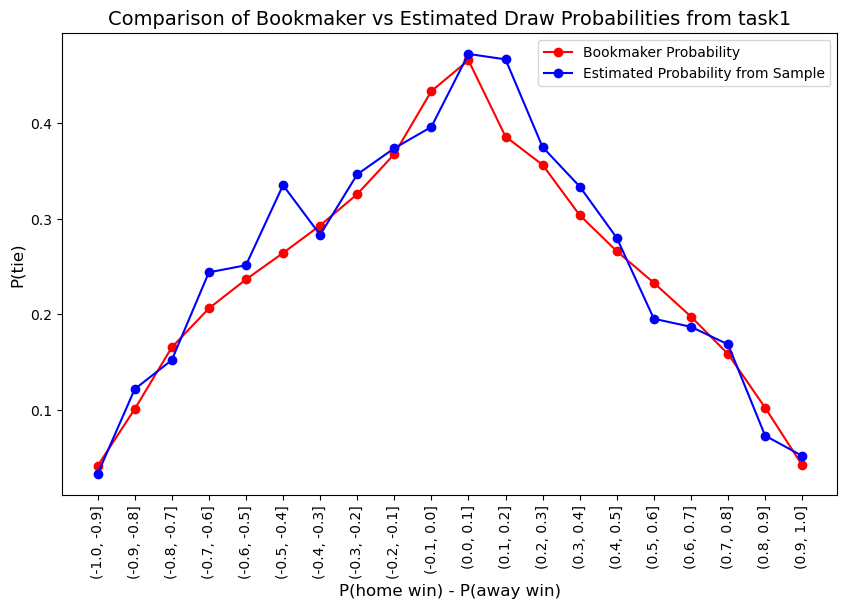

In [20]:
##first results from task1's bar plot is added again for easy interpretation of my conclusions below

plt.figure(figsize=(10, 6))

# Plotting the bookmaker probabilities as a line
plt.plot(draw_prob_by_bin.index.astype(str), draw_prob_by_bin.values, label='Bookmaker Probability', color='red', marker='o')

# Plotting the estimated probabilities as a line
plt.plot(estimated_prob_draw.index.astype(str), estimated_prob_draw.values, label='Estimated Probability from Sample', color='blue', marker='o')

# Adding labels and title
plt.xlabel('P(home win) - P(away win)', fontsize=12)
plt.ylabel('P(tie)', fontsize=12)
plt.title('Comparison of Bookmaker vs Estimated Draw Probabilities from task1', fontsize=14)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.legend()

# Show the plot
plt.show()


In [21]:
min_prob_draw2 = cleaned_df.groupby('delta_P_bin')['P_draw_normalized'].min()
max_prob_draw2 = cleaned_df.groupby('delta_P_bin')['P_draw_normalized'].max()

bin_results_df2 = pd.DataFrame({
    'Min_P_draw_estimated': min_prob_draw2,
    'Max_P_draw_estimated': max_prob_draw2,
    'Estimated_P_draw': estimated_prob_draw2
}).reset_index()
bin_results_df2

/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6703/2609066780.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  min_prob_draw2 = cleaned_df.groupby('delta_P_bin')['P_draw_normalized'].min()
/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6703/2609066780.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_prob_draw2 = cleaned_df.groupby('delta_P_bin')['P_draw_normalized'].max()


,delta_P_bin,Min_P_draw_estimated,Max_P_draw_estimated,Estimated_P_draw
0,"(-1.0, -0.9]",0.019082,0.086860,0.035204
1,"(-0.9, -0.8]",0.049986,0.170096,0.134921
2,"(-0.8, -0.7]",0.098840,0.251504,0.159512
3,"(-0.7, -0.6]",0.116555,0.294929,0.253298
4,"(-0.6, -0.5]",0.165507,0.374155,0.265173
5,"(-0.5, -0.4]",0.171838,0.484045,0.325335
6,"(-0.4, -0.3]",0.207744,0.563486,0.285890
7,"(-0.3, -0.2]",0.217237,0.688559,0.360145
8,"(-0.2, -0.1]",0.233397,0.857114,0.380815
9,"(-0.1, 0.0]",0.233776,0.944444,0.387793


In [22]:

# merging the two dataframes on 'delta_P_bin'
combined_df = pd.merge(bin_results_df, bin_results_df2, on='delta_P_bin', suffixes=('_1', '_2'))

# calculating the difference between the estimated probabilities (for task 1 and task 2)

combined_df['Estimated_P_draw_diff'] = combined_df['Estimated_P_draw_2'] - combined_df['Estimated_P_draw_1'] 

combined_df

,delta_P_bin,Min_P_draw_estimated_1,Max_P_draw_estimated_1,Estimated_P_draw_1,Min_P_draw_estimated_2,Max_P_draw_estimated_2,Estimated_P_draw_2,Estimated_P_draw_diff
0,"(-1.0, -0.9]",0.019082,0.086860,0.032928,0.019082,0.086860,0.035204,0.002275
1,"(-0.9, -0.8]",0.049986,0.171719,0.121766,0.049986,0.170096,0.134921,0.013154
2,"(-0.8, -0.7]",0.098840,0.251504,0.152206,0.098840,0.251504,0.159512,0.007306
3,"(-0.7, -0.6]",0.116555,0.309963,0.244040,0.116555,0.294929,0.253298,0.009258
4,"(-0.6, -0.5]",0.165507,0.374155,0.251451,0.165507,0.374155,0.265173,0.013723
5,"(-0.5, -0.4]",0.171838,0.484045,0.335306,0.171838,0.484045,0.325335,-0.009971
6,"(-0.4, -0.3]",0.207744,0.563486,0.283305,0.207744,0.563486,0.285890,0.002584
7,"(-0.3, -0.2]",0.217237,0.688559,0.346589,0.217237,0.688559,0.360145,0.013556
8,"(-0.2, -0.1]",0.233397,0.857114,0.373924,0.233397,0.857114,0.380815,0.006891
9,"(-0.1, 0.0]",0.233776,0.944444,0.396302,0.233776,0.944444,0.387793,-0.008509


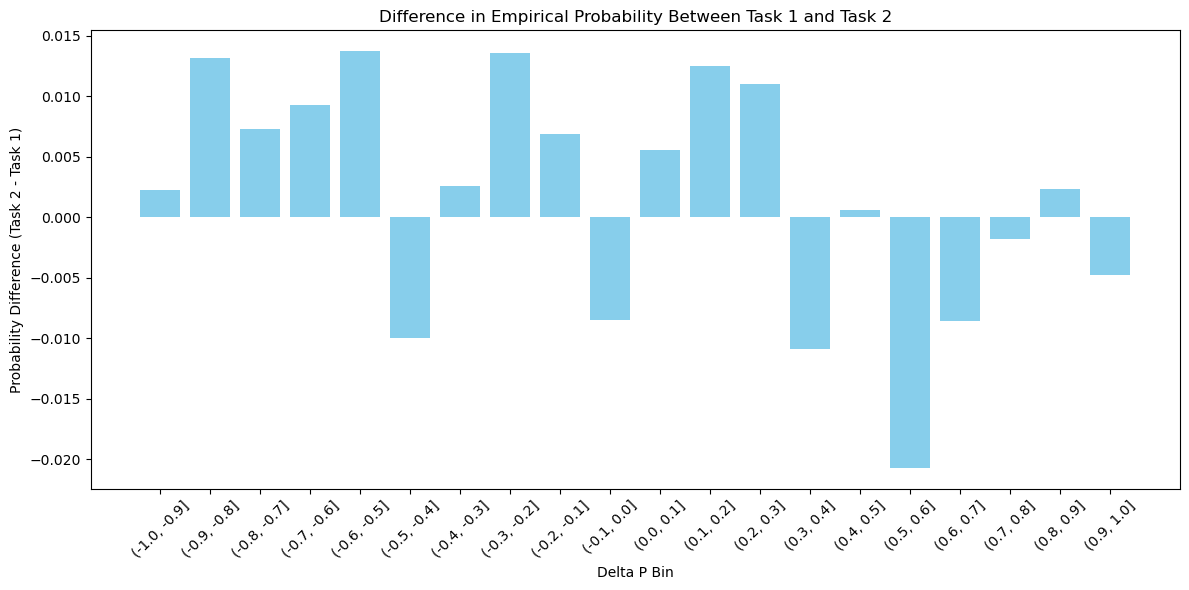

In [23]:
combined_df['delta_P_bin_str'] = combined_df['delta_P_bin'].astype(str)

# Plot the differences
plt.figure(figsize=(12, 6))
plt.bar(combined_df['delta_P_bin_str'], combined_df['Estimated_P_draw_diff'], color='skyblue')
plt.xticks(rotation=45)
plt.xlabel("Delta P Bin")
plt.ylabel("Probability Difference (Task 2 - Task 1)")
plt.title("Difference in Empirical Probability Between Task 1 and Task 2")
plt.tight_layout()
plt.show()

1.	Late Goals (90th Minute or Later):
	•	Matches in which a decisive goal (resulting in a win, draw, or loss) occurred after the 90th minute were removed.

2.	Early Red Cards (First 15 Minutes):
	•	Matches where a red card was issued within the first 15 minutes were excluded.

After completing this filtering the total of 42 matches removed, all because of the early red cards. (no match found with late goals)

Then, the estimated and bookmaker probabilities for draw are re-calculated based on the remaining matches. 

Observations indicate slight shifts in the estimated probabilities across several bins, suggesting the removed matches had non-negligible effects on the probability distributions.

#### New observations: 

Significant increases in estimated probabilities:

	•	Bins like (-0.9, -0.8], (-0.6, -0.5], and (0.1, 0.2] saw increases of over 0.01 in draw probabilities.
	•	Indicates that the removed matches may have biased the probabilities lower in these bins.
    
Significant decreases in estimated probabilities:

	•	Bins like (0.5, 0.6] and (0.3, 0.4] saw decreases of over 0.01, suggesting removed matches had inflated probabilities in these cases.
    
Minor changes (<0.01):

	•	Most other bins exhibit relatively minor changes, indicating that the removed matches had less impact in these ranges.
    
#### Range of Changes:
Maximum positive change: +0.013723 (Bin (-0.6, -0.5]).
Maximum negative change: -0.020710 (Bin (0.5, 0.6]).
    
    
### Interpretation of these changes:

	* Matches with late goals or early red cards appear to disproportionately influence specific probability ranges.
    
	* Removing these matches likely provides a clearer picture of the true probability distribution, reducing the impact of outliers or anomalies.
    
    * As we see slight increases in the estimated probability in the bins near to -1 (better seen in the difference bar plot) we can say that this outlier removal part somehow indicates the likelihood of making profits in these bins are actually higher where we see estimated probabilities are larger than the bookmaker probabilities. 
    
    * However, as we have seen the importance of outlier removal in our analysis, further examination may be needed. For example, also filtering out the matches where an early injury happens, etc. may lead us to even less biased and more real-world-like analysis. 
    
    
## Conclusion

A. Effect of Removed Matches:

Matches removed due to late goals or early red cards had a greater impact on balanced games (bins closer to 0 on the x-axis) than on games with extreme team strength differences.

The changes in estimated probabilities are relatively small across all bins, suggesting that extreme outcomes influence the results but do not drastically alter the overall patterns.

B. Statistical Significance of Changes:

While the changes in estimated draw probabilities are small in magnitude, they indicate a slight adjustment in the observed bias.

The bookmaker's odds continue to underestimate draw probabilities, particularly in balanced matches, even after accounting for extreme outcomes.

C. Bias Observation:

The systematic bias noted in Task1 persists in Task2, indicating that the underestimation of draw probabilities is not solely due to extreme events like red cards or late goals.

## task 3


Suppose you decided to fit a decision tree model to the outcome of the game (i.e. your target is the
result column) and use the statistics for each minute as feature (or some derived feature you end up
with). Each row is an instance in that case. It is about trying to foresee the result of the game given
the current situation.

Set your decision tree learning parameters such that it allows for commenting on the rules you have
identified. Is there any interesting observation regarding the match result?

Your tree may provide insights into if odds are not efficient. In other words, you will obtain a
predicted probability of an outcome from your model and if the deviation of the predicted
probabilities are not close to the implied probabilities, that might hint for an inefficiency in the
market. Do you observe such cases? If so, are they reasonable in terms of what model is telling you?

Note that this part is open-ended and the analyses you will make can provide insights into your
project work.

In [24]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score


from sklearn.model_selection import train_test_split, GridSearchCV


In [25]:
## decided on using the cleaned_df where the matches that red card occurs in the first 15 minutes are filtered out

df3 = cleaned_df.copy()

In [26]:
df3

,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,suspended,stopped,...,P_tie,P_away,P_sum,P_home_normalized,P_draw_normalized,P_away_normalized,delta_P,delta_P_normalized,delta_P_bin,draw_diff
0,19134453.0,1st-half,2024-08-16 19:01:19,2024-08-16 19:00:31,2024-08-16 19:00:31,0,48,2024-08-16 19:01:17,False,False,...,0.250000,0.200000,1.052410,0.572410,0.237550,0.190040,0.402410,0.382370,"(0.3, 0.4]",0.085487
1,19134453.0,1st-half,2024-08-16 19:02:18,2024-08-16 19:00:31,2024-08-16 19:00:31,1,47,2024-08-16 19:02:16,False,False,...,0.250000,0.200000,1.052410,0.572410,0.237550,0.190040,0.402410,0.382370,"(0.3, 0.4]",0.085487
2,19134453.0,1st-half,2024-08-16 19:03:19,2024-08-16 19:00:31,2024-08-16 19:00:31,2,48,2024-08-16 19:03:15,False,False,...,0.250000,0.181818,1.052936,0.589891,0.237431,0.172677,0.439300,0.417214,"(0.4, 0.5]",0.043263
3,19134453.0,1st-half,2024-08-16 19:04:18,2024-08-16 19:00:31,2024-08-16 19:00:31,3,47,2024-08-16 19:04:08,False,False,...,0.250000,0.200000,1.071118,0.579878,0.233401,0.186721,0.421118,0.393157,"(0.3, 0.4]",0.089636
4,19134453.0,1st-half,2024-08-16 19:05:19,2024-08-16 19:00:31,2024-08-16 19:00:31,4,48,2024-08-16 19:05:15,False,False,...,0.250000,0.200000,1.071118,0.579878,0.233401,0.186721,0.421118,0.393157,"(0.3, 0.4]",0.089636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56122,19172117.0,2nd-half,2024-11-10 17:48:41,2024-11-10 17:15:56,2024-11-10 16:03:27,32,45,2024-11-10 17:48:37,False,False,...,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936,"(0.9, 1.0]",0.027904
56123,19172117.0,2nd-half,2024-11-10 17:49:41,2024-11-10 17:15:56,2024-11-10 16:03:27,33,45,2024-11-10 17:49:39,False,False,...,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936,"(0.9, 1.0]",0.027904
56124,19172117.0,2nd-half,2024-11-10 17:50:42,2024-11-10 17:15:56,2024-11-10 16:03:27,34,46,2024-11-10 17:50:39,False,False,...,0.019608,0.002849,1.022457,0.978036,0.019177,0.002786,0.997151,0.975250,"(0.9, 1.0]",0.027911
56125,19172117.0,2nd-half,2024-11-10 17:51:41,2024-11-10 17:15:56,2024-11-10 16:03:27,35,45,2024-11-10 17:51:40,False,False,...,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936,"(0.9, 1.0]",0.027904


In [27]:
df3 = df3.drop(columns = ['suspended','stopped','name','ticking','final_score', 'draw_diff'])
df3

,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,1,2,...,P_home,P_tie,P_away,P_sum,P_home_normalized,P_draw_normalized,P_away_normalized,delta_P,delta_P_normalized,delta_P_bin
0,19134453.0,1st-half,2024-08-16 19:01:19,2024-08-16 19:00:31,2024-08-16 19:00:31,0,48,2024-08-16 19:01:17,1.66,5.0,...,0.602410,0.250000,0.200000,1.052410,0.572410,0.237550,0.190040,0.402410,0.382370,"(0.3, 0.4]"
1,19134453.0,1st-half,2024-08-16 19:02:18,2024-08-16 19:00:31,2024-08-16 19:00:31,1,47,2024-08-16 19:02:16,1.66,5.0,...,0.602410,0.250000,0.200000,1.052410,0.572410,0.237550,0.190040,0.402410,0.382370,"(0.3, 0.4]"
2,19134453.0,1st-half,2024-08-16 19:03:19,2024-08-16 19:00:31,2024-08-16 19:00:31,2,48,2024-08-16 19:03:15,1.61,5.5,...,0.621118,0.250000,0.181818,1.052936,0.589891,0.237431,0.172677,0.439300,0.417214,"(0.4, 0.5]"
3,19134453.0,1st-half,2024-08-16 19:04:18,2024-08-16 19:00:31,2024-08-16 19:00:31,3,47,2024-08-16 19:04:08,1.61,5.0,...,0.621118,0.250000,0.200000,1.071118,0.579878,0.233401,0.186721,0.421118,0.393157,"(0.3, 0.4]"
4,19134453.0,1st-half,2024-08-16 19:05:19,2024-08-16 19:00:31,2024-08-16 19:00:31,4,48,2024-08-16 19:05:15,1.61,5.0,...,0.621118,0.250000,0.200000,1.071118,0.579878,0.233401,0.186721,0.421118,0.393157,"(0.3, 0.4]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56122,19172117.0,2nd-half,2024-11-10 17:48:41,2024-11-10 17:15:56,2024-11-10 16:03:27,32,45,2024-11-10 17:48:37,1.00,401.0,...,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936,"(0.9, 1.0]"
56123,19172117.0,2nd-half,2024-11-10 17:49:41,2024-11-10 17:15:56,2024-11-10 16:03:27,33,45,2024-11-10 17:49:39,1.00,401.0,...,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936,"(0.9, 1.0]"
56124,19172117.0,2nd-half,2024-11-10 17:50:42,2024-11-10 17:15:56,2024-11-10 16:03:27,34,46,2024-11-10 17:50:39,1.00,351.0,...,1.000000,0.019608,0.002849,1.022457,0.978036,0.019177,0.002786,0.997151,0.975250,"(0.9, 1.0]"
56125,19172117.0,2nd-half,2024-11-10 17:51:41,2024-11-10 17:15:56,2024-11-10 16:03:27,35,45,2024-11-10 17:51:40,1.00,401.0,...,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936,"(0.9, 1.0]"


In [28]:
df3['result'] = df3['result'].astype('category')

target_column = 'result'
X = df3.drop(columns=[target_column, 'delta_P_bin'])
y = df3[target_column]

#splitting data step is removed as we will use cross-validation
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# identifying the column types for processing needs
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
datetime_columns = X.select_dtypes(include=['datetime64']).columns.tolist()
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [29]:
X

,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,1,2,...,current_state,P_home,P_tie,P_away,P_sum,P_home_normalized,P_draw_normalized,P_away_normalized,delta_P,delta_P_normalized
0,19134453.0,1st-half,2024-08-16 19:01:19,2024-08-16 19:00:31,2024-08-16 19:00:31,0,48,2024-08-16 19:01:17,1.66,5.0,...,X,0.602410,0.250000,0.200000,1.052410,0.572410,0.237550,0.190040,0.402410,0.382370
1,19134453.0,1st-half,2024-08-16 19:02:18,2024-08-16 19:00:31,2024-08-16 19:00:31,1,47,2024-08-16 19:02:16,1.66,5.0,...,X,0.602410,0.250000,0.200000,1.052410,0.572410,0.237550,0.190040,0.402410,0.382370
2,19134453.0,1st-half,2024-08-16 19:03:19,2024-08-16 19:00:31,2024-08-16 19:00:31,2,48,2024-08-16 19:03:15,1.61,5.5,...,X,0.621118,0.250000,0.181818,1.052936,0.589891,0.237431,0.172677,0.439300,0.417214
3,19134453.0,1st-half,2024-08-16 19:04:18,2024-08-16 19:00:31,2024-08-16 19:00:31,3,47,2024-08-16 19:04:08,1.61,5.0,...,X,0.621118,0.250000,0.200000,1.071118,0.579878,0.233401,0.186721,0.421118,0.393157
4,19134453.0,1st-half,2024-08-16 19:05:19,2024-08-16 19:00:31,2024-08-16 19:00:31,4,48,2024-08-16 19:05:15,1.61,5.0,...,X,0.621118,0.250000,0.200000,1.071118,0.579878,0.233401,0.186721,0.421118,0.393157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56122,19172117.0,2nd-half,2024-11-10 17:48:41,2024-11-10 17:15:56,2024-11-10 16:03:27,32,45,2024-11-10 17:48:37,1.00,401.0,...,1,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936
56123,19172117.0,2nd-half,2024-11-10 17:49:41,2024-11-10 17:15:56,2024-11-10 16:03:27,33,45,2024-11-10 17:49:39,1.00,401.0,...,1,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936
56124,19172117.0,2nd-half,2024-11-10 17:50:42,2024-11-10 17:15:56,2024-11-10 16:03:27,34,46,2024-11-10 17:50:39,1.00,351.0,...,1,1.000000,0.019608,0.002849,1.022457,0.978036,0.019177,0.002786,0.997151,0.975250
56125,19172117.0,2nd-half,2024-11-10 17:51:41,2024-11-10 17:15:56,2024-11-10 16:03:27,35,45,2024-11-10 17:51:40,1.00,401.0,...,1,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936


In [30]:
y

0        1
1        1
2        1
3        1
4        1
        ..
56122    1
56123    1
56124    1
56125    1
56126    1
Name: result, Length: 52511, dtype: category
Categories (3, object): ['1', '2', 'X']

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [32]:
## one hot encoder used for the variable (feature) halftime:
X['halftime'] = X['halftime'].map({'1st-half': 0, '2nd-half': 1})
X

,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,1,2,...,current_state,P_home,P_tie,P_away,P_sum,P_home_normalized,P_draw_normalized,P_away_normalized,delta_P,delta_P_normalized
0,19134453.0,0,2024-08-16 19:01:19,2024-08-16 19:00:31,2024-08-16 19:00:31,0,48,2024-08-16 19:01:17,1.66,5.0,...,X,0.602410,0.250000,0.200000,1.052410,0.572410,0.237550,0.190040,0.402410,0.382370
1,19134453.0,0,2024-08-16 19:02:18,2024-08-16 19:00:31,2024-08-16 19:00:31,1,47,2024-08-16 19:02:16,1.66,5.0,...,X,0.602410,0.250000,0.200000,1.052410,0.572410,0.237550,0.190040,0.402410,0.382370
2,19134453.0,0,2024-08-16 19:03:19,2024-08-16 19:00:31,2024-08-16 19:00:31,2,48,2024-08-16 19:03:15,1.61,5.5,...,X,0.621118,0.250000,0.181818,1.052936,0.589891,0.237431,0.172677,0.439300,0.417214
3,19134453.0,0,2024-08-16 19:04:18,2024-08-16 19:00:31,2024-08-16 19:00:31,3,47,2024-08-16 19:04:08,1.61,5.0,...,X,0.621118,0.250000,0.200000,1.071118,0.579878,0.233401,0.186721,0.421118,0.393157
4,19134453.0,0,2024-08-16 19:05:19,2024-08-16 19:00:31,2024-08-16 19:00:31,4,48,2024-08-16 19:05:15,1.61,5.0,...,X,0.621118,0.250000,0.200000,1.071118,0.579878,0.233401,0.186721,0.421118,0.393157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56122,19172117.0,1,2024-11-10 17:48:41,2024-11-10 17:15:56,2024-11-10 16:03:27,32,45,2024-11-10 17:48:37,1.00,401.0,...,1,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936
56123,19172117.0,1,2024-11-10 17:49:41,2024-11-10 17:15:56,2024-11-10 16:03:27,33,45,2024-11-10 17:49:39,1.00,401.0,...,1,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936
56124,19172117.0,1,2024-11-10 17:50:42,2024-11-10 17:15:56,2024-11-10 16:03:27,34,46,2024-11-10 17:50:39,1.00,351.0,...,1,1.000000,0.019608,0.002849,1.022457,0.978036,0.019177,0.002786,0.997151,0.975250
56125,19172117.0,1,2024-11-10 17:51:41,2024-11-10 17:15:56,2024-11-10 16:03:27,35,45,2024-11-10 17:51:40,1.00,401.0,...,1,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936


In [33]:
# date columns are turned to numeric format
date_columns = ['current_time', 'half_start_datetime', 'match_start_datetime','latest_bookmaker_update']

for col in date_columns:
    print(f"Processing datetime column: {col}")
    X[col] = pd.to_datetime(X[col], errors='coerce')
    
    
    # Convert to Unix timestamp (seconds)
    X[col] = X[col].astype('int64') // 10**9

X

Processing datetime column: current_time
Processing datetime column: half_start_datetime
Processing datetime column: match_start_datetime
Processing datetime column: latest_bookmaker_update


,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,1,2,...,current_state,P_home,P_tie,P_away,P_sum,P_home_normalized,P_draw_normalized,P_away_normalized,delta_P,delta_P_normalized
0,19134453.0,0,1723834879,1723834831,1723834831,0,48,1723834877,1.66,5.0,...,X,0.602410,0.250000,0.200000,1.052410,0.572410,0.237550,0.190040,0.402410,0.382370
1,19134453.0,0,1723834938,1723834831,1723834831,1,47,1723834936,1.66,5.0,...,X,0.602410,0.250000,0.200000,1.052410,0.572410,0.237550,0.190040,0.402410,0.382370
2,19134453.0,0,1723834999,1723834831,1723834831,2,48,1723834995,1.61,5.5,...,X,0.621118,0.250000,0.181818,1.052936,0.589891,0.237431,0.172677,0.439300,0.417214
3,19134453.0,0,1723835058,1723834831,1723834831,3,47,1723835048,1.61,5.0,...,X,0.621118,0.250000,0.200000,1.071118,0.579878,0.233401,0.186721,0.421118,0.393157
4,19134453.0,0,1723835119,1723834831,1723834831,4,48,1723835115,1.61,5.0,...,X,0.621118,0.250000,0.200000,1.071118,0.579878,0.233401,0.186721,0.421118,0.393157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56122,19172117.0,1,1731260921,1731258956,1731254607,32,45,1731260917,1.00,401.0,...,1,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936
56123,19172117.0,1,1731260981,1731258956,1731254607,33,45,1731260979,1.00,401.0,...,1,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936
56124,19172117.0,1,1731261042,1731258956,1731254607,34,46,1731261039,1.00,351.0,...,1,1.000000,0.019608,0.002849,1.022457,0.978036,0.019177,0.002786,0.997151,0.975250
56125,19172117.0,1,1731261101,1731258956,1731254607,35,45,1731261100,1.00,401.0,...,1,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936


In [34]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding for target column 'result' as there are three categories X-1-2
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print("Transformed y:", y[:5])


Transformed y: [0 0 0 0 0]


In [35]:
# One-Hot Encoding for the 'current_state' column
X = pd.get_dummies(X, columns=['current_state'], prefix='current_state')

print("Transformed :", X.head())


Transformed :    fixture_id  halftime  current_time  half_start_datetime  \
0  19134453.0         0    1723834879           1723834831   
1  19134453.0         0    1723834938           1723834831   
2  19134453.0         0    1723834999           1723834831   
3  19134453.0         0    1723835058           1723834831   
4  19134453.0         0    1723835119           1723834831   

   match_start_datetime  minute  second  latest_bookmaker_update     1    2  \
0            1723834831       0      48               1723834877  1.66  5.0   
1            1723834831       1      47               1723834936  1.66  5.0   
2            1723834831       2      48               1723834995  1.61  5.5   
3            1723834831       3      47               1723835048  1.61  5.0   
4            1723834831       4      48               1723835115  1.61  5.0   

   ...     P_sum  P_home_normalized  P_draw_normalized  P_away_normalized  \
0  ...  1.052410           0.572410           0.237550       

In [36]:
X

,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,1,2,...,P_sum,P_home_normalized,P_draw_normalized,P_away_normalized,delta_P,delta_P_normalized,current_state_0,current_state_1,current_state_2,current_state_X
0,19134453.0,0,1723834879,1723834831,1723834831,0,48,1723834877,1.66,5.0,...,1.052410,0.572410,0.237550,0.190040,0.402410,0.382370,False,False,False,True
1,19134453.0,0,1723834938,1723834831,1723834831,1,47,1723834936,1.66,5.0,...,1.052410,0.572410,0.237550,0.190040,0.402410,0.382370,False,False,False,True
2,19134453.0,0,1723834999,1723834831,1723834831,2,48,1723834995,1.61,5.5,...,1.052936,0.589891,0.237431,0.172677,0.439300,0.417214,False,False,False,True
3,19134453.0,0,1723835058,1723834831,1723834831,3,47,1723835048,1.61,5.0,...,1.071118,0.579878,0.233401,0.186721,0.421118,0.393157,False,False,False,True
4,19134453.0,0,1723835119,1723834831,1723834831,4,48,1723835115,1.61,5.0,...,1.071118,0.579878,0.233401,0.186721,0.421118,0.393157,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56122,19172117.0,1,1731260921,1731258956,1731254607,32,45,1731260917,1.00,401.0,...,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936,False,True,False,False
56123,19172117.0,1,1731260981,1731258956,1731254607,33,45,1731260979,1.00,401.0,...,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936,False,True,False,False
56124,19172117.0,1,1731261042,1731258956,1731254607,34,46,1731261039,1.00,351.0,...,1.022457,0.978036,0.019177,0.002786,0.997151,0.975250,False,True,False,False
56125,19172117.0,1,1731261101,1731258956,1731254607,35,45,1731261100,1.00,401.0,...,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936,False,True,False,False


In [37]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
# defining the Random Forest and parameter grid
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200,300,400,500],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [10, 20, 50]
}

# performing the GridSearch with cross-validation
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_log_loss', return_train_score=False)
grid_rf.fit(X, y)

# best model in the given parameter grid
best_rf = grid_rf.best_estimator_
print("Best Random Forest Parameters:", grid_rf.best_params_)



Best Random Forest Parameters: {'max_depth': 5, 'min_samples_leaf': 50, 'n_estimators': 400}


In [39]:
results_df = pd.DataFrame(grid_rf.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.789546,0.029386,0.015966,0.001117,3,10,100,"{'max_depth': 3, 'min_samples_leaf': 10, 'n_es...",-0.867845,-0.771153,-0.788204,-0.788415,-0.821841,-0.807492,0.034365,32
1,3.755867,0.099885,0.029819,0.002125,3,10,200,"{'max_depth': 3, 'min_samples_leaf': 10, 'n_es...",-0.868542,-0.773934,-0.790033,-0.789516,-0.821650,-0.808735,0.033687,35
2,5.474201,0.016040,0.039342,0.000467,3,10,300,"{'max_depth': 3, 'min_samples_leaf': 10, 'n_es...",-0.868826,-0.775442,-0.791083,-0.791076,-0.821992,-0.809684,0.033209,38
3,7.284029,0.016740,0.051039,0.000340,3,10,400,"{'max_depth': 3, 'min_samples_leaf': 10, 'n_es...",-0.869295,-0.775158,-0.790757,-0.791734,-0.822581,-0.809905,0.033442,44
4,9.099145,0.032204,0.063944,0.001521,3,10,500,"{'max_depth': 3, 'min_samples_leaf': 10, 'n_es...",-0.869623,-0.774985,-0.790496,-0.791542,-0.822336,-0.809797,0.033627,41
5,1.833081,0.003370,0.015188,0.000514,3,20,100,"{'max_depth': 3, 'min_samples_leaf': 20, 'n_es...",-0.867956,-0.771144,-0.788197,-0.788396,-0.821836,-0.807506,0.034409,33
6,3.666328,0.013491,0.027057,0.000089,3,20,200,"{'max_depth': 3, 'min_samples_leaf': 20, 'n_es...",-0.868610,-0.773933,-0.790030,-0.789529,-0.821655,-0.808751,0.033710,36
7,5.636666,0.126709,0.043228,0.002855,3,20,300,"{'max_depth': 3, 'min_samples_leaf': 20, 'n_es...",-0.868870,-0.775443,-0.791079,-0.791061,-0.821994,-0.809690,0.033226,39
8,7.285646,0.013221,0.051378,0.000461,3,20,400,"{'max_depth': 3, 'min_samples_leaf': 20, 'n_es...",-0.869355,-0.775160,-0.790757,-0.791712,-0.822583,-0.809913,0.033466,45
9,9.254854,0.198181,0.065601,0.002635,3,20,500,"{'max_depth': 3, 'min_samples_leaf': 20, 'n_es...",-0.869677,-0.774983,-0.790496,-0.791524,-0.822337,-0.809804,0.033649,42


In [40]:
results_summary = results_df[
    ['param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'mean_test_score']
].copy()

results_summary.rename(
    columns={
        'param_n_estimators': 'n_estimators',
        'param_max_depth': 'max_depth',
        'param_min_samples_leaf': 'min_samples_leaf',
        'mean_test_score': 'mean_neg_log_loss_test',
    },
    inplace=True
)


# taking the negative of the log-loss values for easier understanding, this way higher is better.
results_summary['mean_log_loss_test'] = -results_summary['mean_neg_log_loss_test']

# results sorted by test performance
results_summary.sort_values(by='mean_log_loss_test', ascending=False, inplace=True)
results_summary

,n_estimators,max_depth,min_samples_leaf,mean_neg_log_loss_test,mean_log_loss_test
8,400,3,20,-0.809913,0.809913
3,400,3,10,-0.809905,0.809905
13,400,3,50,-0.809834,0.809834
9,500,3,20,-0.809804,0.809804
4,500,3,10,-0.809797,0.809797
14,500,3,50,-0.809748,0.809748
7,300,3,20,-0.809690,0.809690
2,300,3,10,-0.809684,0.809684
12,300,3,50,-0.809612,0.809612
6,200,3,20,-0.808751,0.808751


In [41]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import log_loss, make_scorer

# adding the new log loss 
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# performing the 5-fold cross-validation on the best model with chosen parameters
cv_results = cross_validate(
    best_rf,              
    X,               
    y,               
    cv=5,                 
    scoring={'log_loss': log_loss_scorer, 'accuracy': 'accuracy'},
    return_train_score=False  # due to high computational needs, train scores are not kept.
)

# calculating mean and standard deviation of the scores
mean_log_loss = cv_results['test_log_loss'].mean()  
std_log_loss = cv_results['test_log_loss'].std()

mean_accuracy = cv_results['test_accuracy'].mean()
std_accuracy = cv_results['test_accuracy'].std()

print(f"Random Forest Log Loss (Mean): {-mean_log_loss:.4f}" )
print(f"Random Forest Accuracy (Mean): {mean_accuracy:.4f}")

/Users/yagmurozdemir/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Random Forest Log Loss (Mean): 0.7933
Random Forest Accuracy (Mean): 0.6452


In [42]:
#  best-case values for max_depth and min_samples_leaf
best_params = grid_rf.best_params_
best_max_depth = best_params['max_depth']
best_min_samples_leaf = best_params['min_samples_leaf']

# results for each parameter analysis
# 1. effect of `n_estimators`
n_estimators_results = results_summary[
    (results_summary['max_depth'] == best_max_depth) &
    (results_summary['min_samples_leaf'] == best_min_samples_leaf)
]

# 2. effect of `max_depth`
max_depth_results = results_summary[
    (results_summary['n_estimators'] == best_params['n_estimators']) &
    (results_summary['min_samples_leaf'] == best_min_samples_leaf)
]

# 3. effect of `min_samples_leaf`
min_samples_leaf_results = results_summary[
    (results_summary['n_estimators'] == best_params['n_estimators']) &
    (results_summary['max_depth'] == best_max_depth)
]




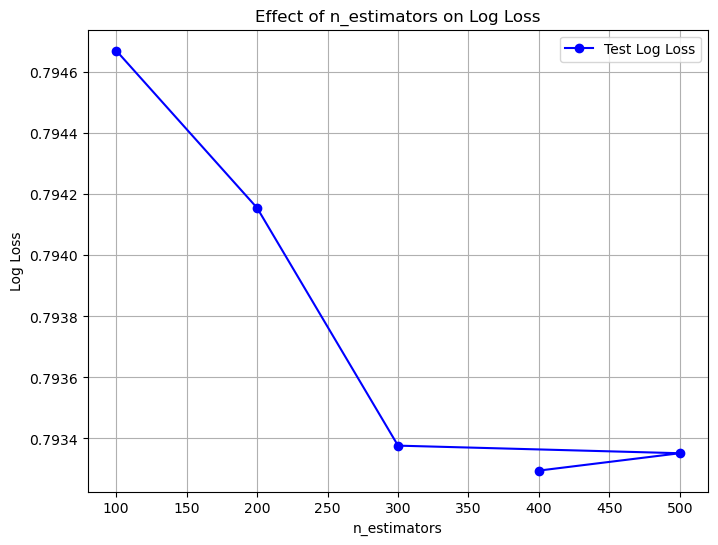

In [43]:
# Plotting function
def plot_parameter_effect(df, x_param, title):
    plt.figure(figsize=(8, 6))
    plt.plot(df[x_param], df['mean_log_loss_test'], label='Test Log Loss', marker='o', linestyle='-', color='blue')
    plt.xlabel(x_param)
    plt.ylabel('Log Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_parameter_effect(n_estimators_results, 'n_estimators', 'Effect of n_estimators on Log Loss')

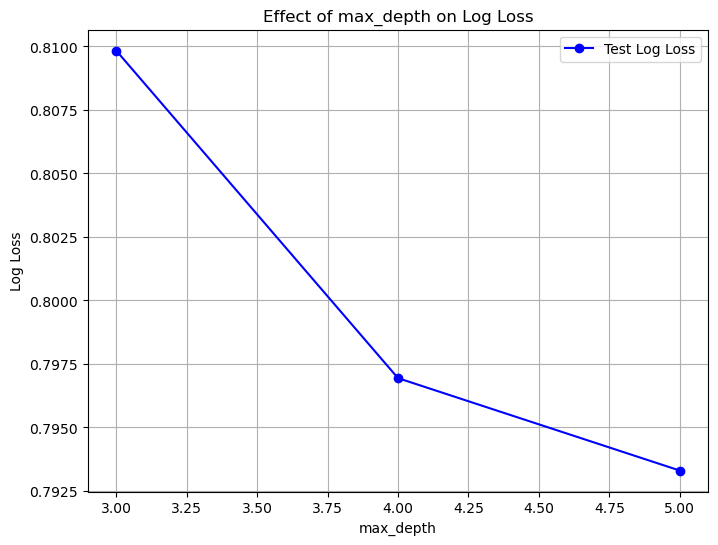

In [44]:
plot_parameter_effect(max_depth_results, 'max_depth', 'Effect of max_depth on Log Loss')


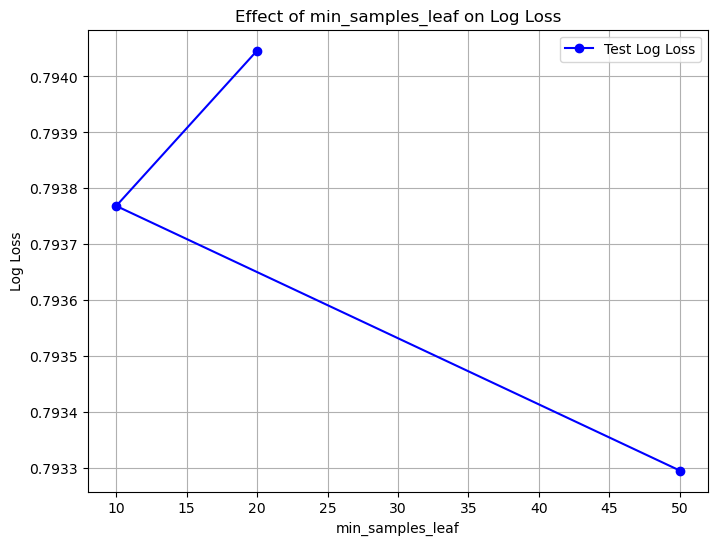

In [45]:
plot_parameter_effect(min_samples_leaf_results, 'min_samples_leaf', 'Effect of min_samples_leaf on Log Loss')

1. Effect of n_estimators on Log Loss:

Increasing the number of trees consistently reduced the log loss up to 400 estimators, after which the improvement plateaued.

This suggests that beyond 400 trees, adding more trees does not significantly improve the model's predictive power.

2. Effect of max_depth on Log Loss:

Increasing max_depth improves the model's performance up to a depth of 5.

Shallower trees (e.g., max_depth=3) have higher log loss, indicating underfitting.

Depths beyond 5 might lead to overfitting, but this is constrained by the chosen parameter grid.

3. Effect of min_samples_leaf on Log Loss:

A larger min_samples_leaf value (e.g., 50) resulted in lower log loss compared to smaller values.

This indicates that restricting the minimum number of samples per leaf node helps prevent overfitting and leads to better generalization.

However, it also requires further analysis as the last plot shows a contuniously decreasing line with increasing minimum number of samples in leaf parameter. However, due to computational weight of these processes, I have decided to go on with the chosen best parameter values from the grid search I have already applied which are:

Best Random Forest Parameters: {'max_depth': 5, 'min_samples_leaf': 50, 'n_estimators': 400}


### analysis of market efficiency with the new model

In [46]:
df3

,fixture_id,halftime,current_time,half_start_datetime,match_start_datetime,minute,second,latest_bookmaker_update,1,2,...,P_home,P_tie,P_away,P_sum,P_home_normalized,P_draw_normalized,P_away_normalized,delta_P,delta_P_normalized,delta_P_bin
0,19134453.0,1st-half,2024-08-16 19:01:19,2024-08-16 19:00:31,2024-08-16 19:00:31,0,48,2024-08-16 19:01:17,1.66,5.0,...,0.602410,0.250000,0.200000,1.052410,0.572410,0.237550,0.190040,0.402410,0.382370,"(0.3, 0.4]"
1,19134453.0,1st-half,2024-08-16 19:02:18,2024-08-16 19:00:31,2024-08-16 19:00:31,1,47,2024-08-16 19:02:16,1.66,5.0,...,0.602410,0.250000,0.200000,1.052410,0.572410,0.237550,0.190040,0.402410,0.382370,"(0.3, 0.4]"
2,19134453.0,1st-half,2024-08-16 19:03:19,2024-08-16 19:00:31,2024-08-16 19:00:31,2,48,2024-08-16 19:03:15,1.61,5.5,...,0.621118,0.250000,0.181818,1.052936,0.589891,0.237431,0.172677,0.439300,0.417214,"(0.4, 0.5]"
3,19134453.0,1st-half,2024-08-16 19:04:18,2024-08-16 19:00:31,2024-08-16 19:00:31,3,47,2024-08-16 19:04:08,1.61,5.0,...,0.621118,0.250000,0.200000,1.071118,0.579878,0.233401,0.186721,0.421118,0.393157,"(0.3, 0.4]"
4,19134453.0,1st-half,2024-08-16 19:05:19,2024-08-16 19:00:31,2024-08-16 19:00:31,4,48,2024-08-16 19:05:15,1.61,5.0,...,0.621118,0.250000,0.200000,1.071118,0.579878,0.233401,0.186721,0.421118,0.393157,"(0.3, 0.4]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56122,19172117.0,2nd-half,2024-11-10 17:48:41,2024-11-10 17:15:56,2024-11-10 16:03:27,32,45,2024-11-10 17:48:37,1.00,401.0,...,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936,"(0.9, 1.0]"
56123,19172117.0,2nd-half,2024-11-10 17:49:41,2024-11-10 17:15:56,2024-11-10 16:03:27,33,45,2024-11-10 17:49:39,1.00,401.0,...,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936,"(0.9, 1.0]"
56124,19172117.0,2nd-half,2024-11-10 17:50:42,2024-11-10 17:15:56,2024-11-10 16:03:27,34,46,2024-11-10 17:50:39,1.00,351.0,...,1.000000,0.019608,0.002849,1.022457,0.978036,0.019177,0.002786,0.997151,0.975250,"(0.9, 1.0]"
56125,19172117.0,2nd-half,2024-11-10 17:51:41,2024-11-10 17:15:56,2024-11-10 16:03:27,35,45,2024-11-10 17:51:40,1.00,401.0,...,1.000000,0.019608,0.002494,1.022102,0.978376,0.019184,0.002440,0.997506,0.975936,"(0.9, 1.0]"


In [47]:

# `P_home_normalized`, `P_draw_normalized`, and `P_away_normalized` are the normalized bookmaker probabilities
bookmaker_probs = df3[['P_home_normalized', 'P_draw_normalized', 'P_away_normalized']].values

# getting the predicted probabilities from the trained Random Forest model
model_predicted_probs = best_rf.predict_proba(X)
model_predicted_probs


array([[0.57104412, 0.12979369, 0.29916219],
       [0.57567983, 0.12864434, 0.29567583],
       [0.55491177, 0.12876996, 0.31631827],
       ...,
       [0.94777494, 0.01050227, 0.04172279],
       [0.94753053, 0.01060013, 0.04186935],
       [0.94635385, 0.01225353, 0.04139263]])

In [48]:
# calculating deviations between model predictions and bookmaker probabilities
deviations = model_predicted_probs - bookmaker_probs

# summary statistics for deviations
mean_deviation = np.mean(deviations, axis=0)
abs_mean_deviation = np.mean(np.abs(deviations), axis=0)

df3['home_dev'] = deviations[:, 0]
df3['draw_dev'] = deviations[:, 1]
df3['away_dev'] = deviations[:, 2]
df3['max_abs_dev'] = np.abs(deviations).max(axis=1)

# threshold for significance of deviation chosen as = 0.1 
significant_deviation_threshold = 0.1
df3['significant_deviation'] = df3['max_abs_dev'] > significant_deviation_threshold

# analyzing matches with significant deviations
significant_deviation_count = df3['significant_deviation'].sum()
significant_deviations_summary = df3[df3['significant_deviation']].groupby('delta_P_bin')['significant_deviation'].count()

print(f"Mean Deviation: {mean_deviation}")
print(f"Mean Absolute Deviation: {abs_mean_deviation}")
print(f"Number of Matches with Significant Deviation: {significant_deviation_count}")
print("Significant Deviations by Delta_P Bin:")
print(significant_deviations_summary)

print('total number of observations with significant deviations')
print(significant_deviations_summary.sum())

Mean Deviation: [ 0.00584148  0.0274524  -0.03329388]
Mean Absolute Deviation: [0.03103712 0.23575883 0.23227838]
Number of Matches with Significant Deviation: 38231
Significant Deviations by Delta_P Bin:
delta_P_bin
(-1.0, -0.9]    1818
(-0.9, -0.8]    2016
(-0.8, -0.7]    1887
(-0.7, -0.6]    1516
(-0.6, -0.5]    1384
(-0.5, -0.4]    1388
(-0.4, -0.3]    1514
(-0.3, -0.2]    1862
(-0.2, -0.1]    2184
(-0.1, 0.0]     1973
(0.0, 0.1]      2869
(0.1, 0.2]      3142
(0.2, 0.3]      2551
(0.3, 0.4]      2423
(0.4, 0.5]      2227
(0.5, 0.6]      1864
(0.6, 0.7]      2301
(0.7, 0.8]      2140
(0.8, 0.9]      1070
(0.9, 1.0]       102
Name: significant_deviation, dtype: int64
total number of observations with significant deviations
38231


/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6703/3424028208.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  significant_deviations_summary = df3[df3['significant_deviation']].groupby('delta_P_bin')['significant_deviation'].count()



Observations:

- Out of a total of 52,511 observations, 38,231 observations exhibit significant deviations (deviations greater than the threshold of 0.1).

- This constitutes a significant portion of the dataset (approximately 72.8%), indicating that the model’s predicted probabilities often diverge considerably from the bookmaker probabilities.

- The distribution (below) shows that while a large number of matches have small deviations, a substantial number of matches exceed the threshold, with some outliers reaching deviations as high as 0.6 to 0.8.

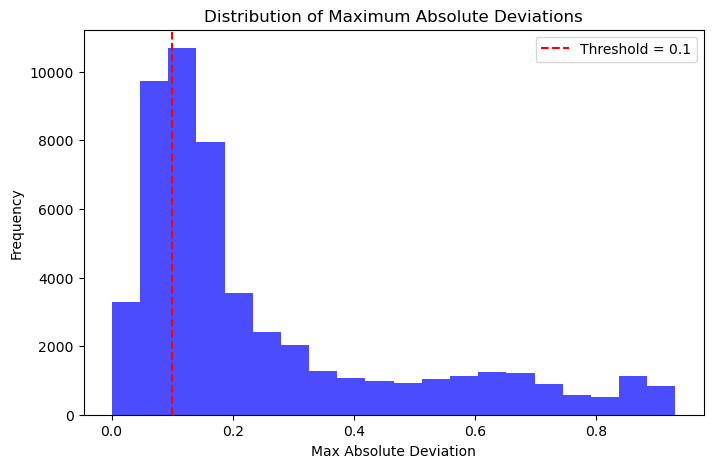

/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6703/2325815351.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df3.groupby('delta_P_bin')['max_abs_dev'].mean().plot(kind='bar', figsize=(10, 5), color='skyblue')


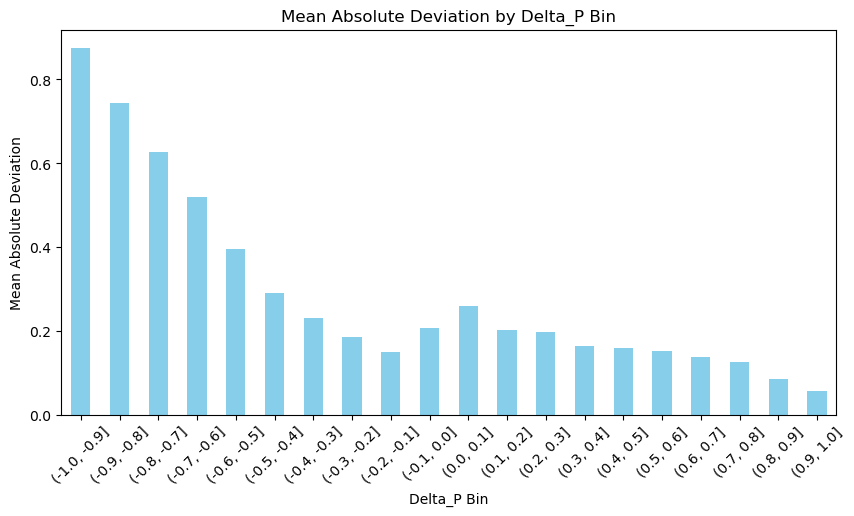

In [49]:


# Histogram of absolute deviations
plt.figure(figsize=(8, 5))
plt.hist(df3['max_abs_dev'], bins=20, alpha=0.7, color='blue')
plt.axvline(significant_deviation_threshold, color='red', linestyle='--', label='Threshold = 0.1')
plt.title('Distribution of Maximum Absolute Deviations')
plt.xlabel('Max Absolute Deviation')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot deviations by delta_P_bin
df3.groupby('delta_P_bin')['max_abs_dev'].mean().plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title('Mean Absolute Deviation by Delta_P Bin')
plt.xlabel('Delta_P Bin')
plt.ylabel('Mean Absolute Deviation')
plt.xticks(rotation=45)
plt.show()

## conclusions

The high number of significant deviations suggests that bookmaker odds may not fully reflect the game dynamics captured by the model.

These deviations could be attributed to factors not considered by the bookmakers (e.g., in-game statistics, unexpected game events).

The large fraction of significant deviations underscores potential inefficiencies in the market that could be exploited.

Other observations:

1. The mean absolute deviation is highest in extreme bins such as (-1.0, -0.9] and (-0.9, -0.8], where one team is significantly stronger or weaker.

2. The deviations decrease progressively as delta_P_bin moves closer to 0, reaching the lowest levels in balanced games (e.g., (0.0, 0.1]).

3. Balanced games exhibit lower deviations, while extreme matches have higher deviations, especially in cases where the bookmaker odds diverge from the model’s predictions.

Comments on these:

The high deviations in extreme bins indicate that bookmaker odds might struggle to accurately represent extreme imbalances in team strength or dynamics.

Lower deviations in balanced games suggest that bookmakers are more focused on setting precise odds for closely contested matches, which often draw more betting attention.

Matches in extreme bins reflect notable inefficiencies in the market, as the bookmaker’s odds diverge significantly from the model’s probabilities. Balanced games, with lower deviations, align more closely with the model’s predictions, highlighting a focus on accurate odds in these cases.

In conclusion we can state these 3 conclusions from the above analysis:

1. Market Efficiency: While bookmaker odds are broadly efficient for balanced games, they show significant inefficiencies in extreme cases, as evidenced by the high deviations in those bins.

2. Opportunities for Bettors: Significant deviations represent opportunities for bettors to exploit mismatches between bookmaker odds and model predictions, particularly in extreme bins.

3. Balanced Games:Lower deviations in balanced matches reflect the bookmaker’s focus on minimizing risk for these high-stakes scenarios.